# Zadání

#### Monitoring odezvy pingu (20b)
Produkt: jupyter notebook (příp. skript), který posílá pingy na vhodně vybraný server. Stanovíte si rozumnou mez round-trip-time (RTT) pro odpověď, kdy bude považována za úspěch (X=1), pokud pong překročí tuto mez nebo nedorazí vůbec, počítáte neúspěch (X=0). Cílem je sekvenčně modelovat pravděpodobnost úspěšné odezvy p(X=1). Skript by měl obsahovat parametr, který určí, kolik pingů se pošle jednorázově. Při jednom modelujete Bernoulliho rozdělením, při více pingách binomickým. Apriorno je beta. Vykresluje se vývoj bodového odhadu pravděpodobnosti +/- 3 směrodatné odchylky (odmocniny z variance).

# Řešení

## Knihovny

In [36]:
import math
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
from scipy.stats import beta

## Ping

count     30.000000
mean      15.438633
std       25.229934
min        9.976000
25%       10.542250
50%       10.741500
75%       11.207250
max      148.997000
dtype: float64

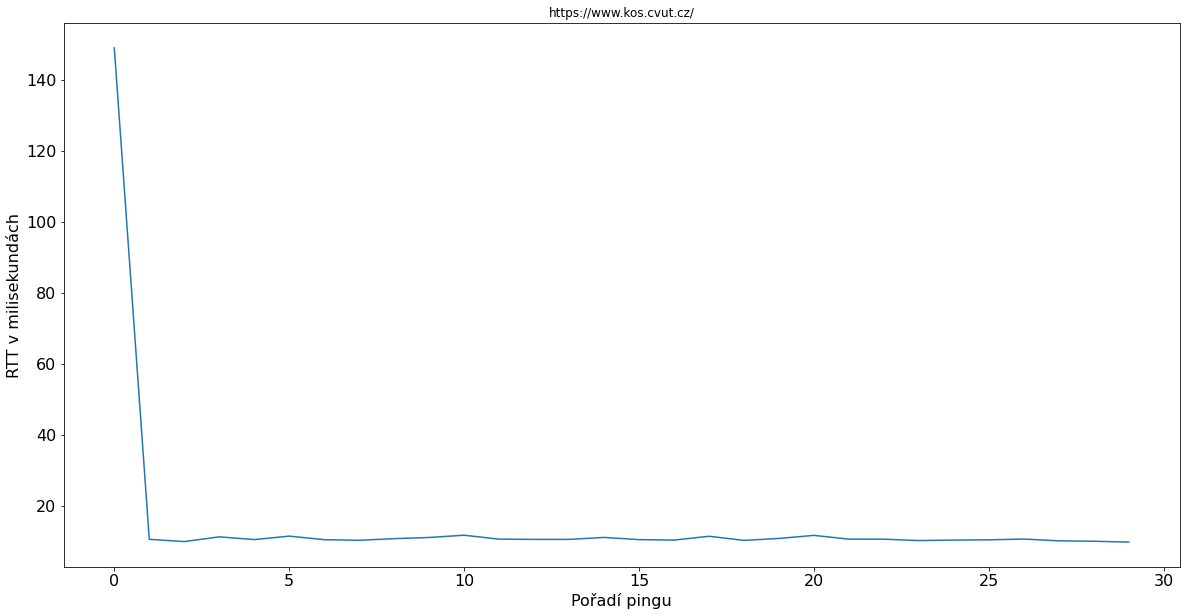

In [37]:
def ping_time(n, url):
    """Perform n pings to url and return their RTT in ms as iterable"""
    rtt = list()
    session = requests.Session()
    for i in range(n):
        r = session.get(url)
        time = r.elapsed.total_seconds()
        rtt.append(time)
    return list(map(lambda x: 1000*x, rtt)) # seconds to milliseconds

url = 'https://www.kos.cvut.cz/'
n = 30

# priklad jednoho pingu
rtt = ping_time(n, url)
df = pd.Series(rtt)

ax = df.plot(figsize=(20,10), title=url, fontsize=16);
ax.set_xlabel('Pořadí pingu', fontsize=16)
ax.set_ylabel('RTT v milisekundách', fontsize=16)
df.describe()

## Sekvenční modelování pravděpodobnosti úspěchu odezvy

### Apriorní distribuce

Podle zadání jako apriori pro rozdělení pravděpodobnosti použiji $Beta(a, b)$ distribuci.
Důvod pro použití $Beta(a,b)$ distribuce je pravděpodobně takový, že sdružená pravděpodobnost $Beta(a,b) \cdot Binom(n, p)$ je zase $Beta$, tedy

$$
\begin{aligned}
Beta(a,b) \cdot Binom(n, p)
& \propto p^{a-1} (1-p)^{b-1} \cdot p^k(1-p)^{n-k}\\
&= p^{a-1+k} (1-p)^{b-1+n-k} \\
&= p^{(a+k)-1} (1-p)^{(b+n-k)-1} \\
&= p^{a_1-1} (1-p)^{b_1-1}\,|\, a_1 = a+k, b_1 = b+n-k\\
&\propto Beta(a_1, b_1)
\end{aligned}
$$

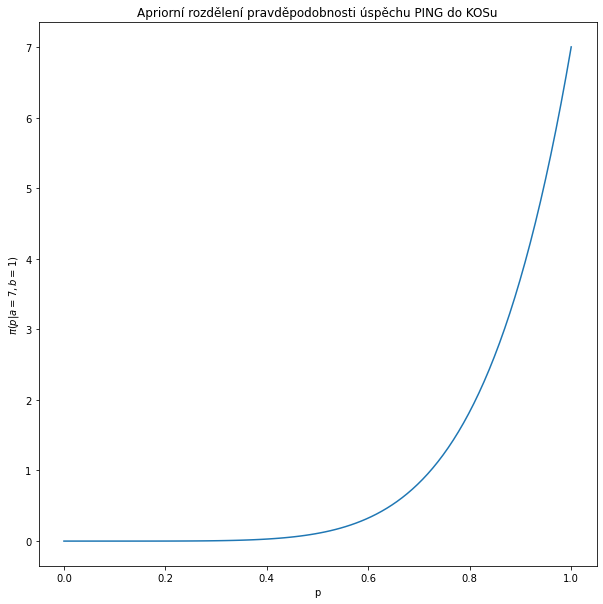

In [38]:
a0 = 7                            ### Počet úspěchů
b0 = 1                            ### Počet neúspěchů
xticks = np.linspace(0, 1, 100)
beta_apriorni = beta.pdf(xticks, a0, b0)
plt.figure(figsize=(10,10))
plt.plot(xticks, beta_apriorni)
plt.xlabel('p')
plt.ylabel(f'$\pi(p|a={a0}, b={b0})$')
plt.title(f'Apriorní rozdělení pravděpodobnosti úspěchu PING do KOSu')
plt.show()

Předpokládám, že PING do KOsu bude většinou úspěšný (pro úspěch definovaný dále).
$Beta$ distribuce mi ale přijde jako špatné apriorní rozdělení pro KOS. Ten má vlastnost, že funguje, pokud se neotvírají zápisy do rozvrhu a podobně. Lepší by bylo do modelu zapracovat časovou analýzu. To ale s $Beta$ distribucí nelze.

### Aposteriorní distribuce

Postupně budu posílat PINGy a updatovat tak můj model. Protože používám $Beta(a,b)$, tak podle předchozího textu u apriorní distribuce bude updatovaná distribuce $Beta(a_1, b_1)$, kde $a_1 = a + \#úspěšných\, pingů$ a $b_1 = b + \#neúspěšných \, pingů$.

Střední hodnota se pro $Beta(a,b)$ vypočítá jako $\dfrac{a}{a+b}$.

Rozptyl (variance) se podle [Wikipedie](https://en.wikipedia.org/wiki/Beta_distribution) vypočítá jako $\dfrac{ab}{(a+b)^2 (a+b+1)}$.

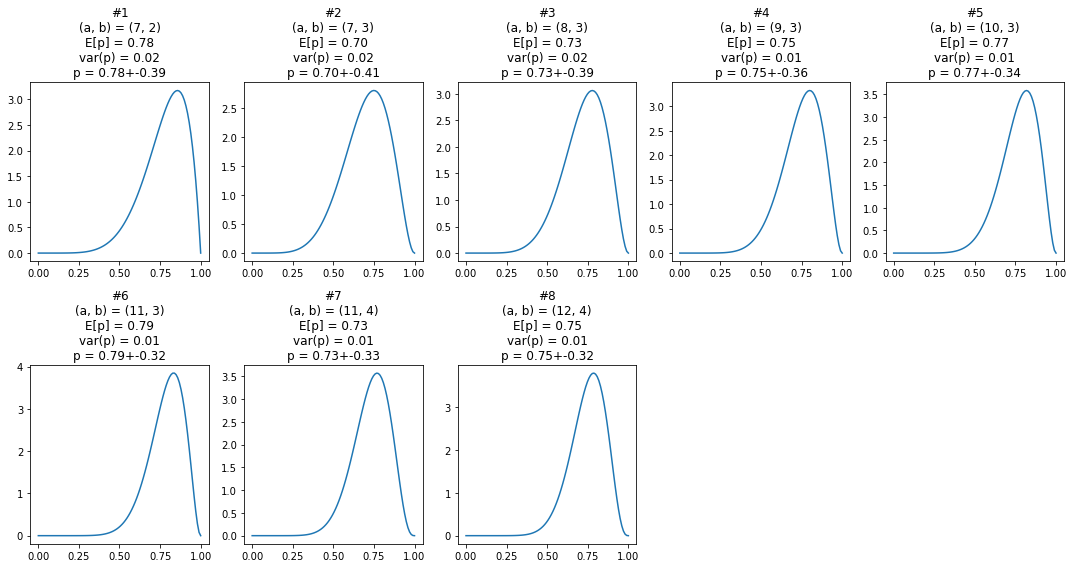

In [59]:
limit = 11 # za touto hranici v milisekundách se ping pocita jako neuspesny
nsamples = 1 # kolik pingu poslat najednout (pro= =1 degeneruje na Bernoulli)
nupdates = 8 # kolik updatu apriorni rozdeleni se provede
url = 'https://www.kos.cvut.cz/' # url, na kterou se budou pingy posilat
a, b = a0, b0

# matplotlib prep
ncol = 5
nrow = math.ceil(nupdates / ncol)
fig, axs = plt.subplots(nrow, ncol, figsize=(15,nrow*4))
axs = axs.ravel() # flatten 2D for easy indexing
[ x.remove() for x in axs[nupdates:]] # remove escessive plots
xticks = np.linspace(0, 1, 100)


for i in range(nupdates):
    OK =  sum(list(map(lambda x: x <= limit, ping_time(nsamples, url))))
    FAIL = nsamples - OK
    a = a + OK
    b = b + FAIL
    var = (a*b) / ( (a+b)**2 * (a+b+1) )
    std = math.sqrt(var)
    mean =  a / (a+b)
    
    # matplotlib
    axs[i].set_title(
            f'#{i+1}\n'
            f'(a, b) = ({a}, {b})\n'
            f'E[p] = {mean:0.2f}\n'
            f'var(p) = {var:0.2f}\n'
            f'p = {mean:.2f}+-{3*std:.2f}'
           )
    dist = beta.pdf(xticks, a, b)
    axs[i].plot(xticks, dist)
    
fig.tight_layout()